In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
# Define dataset paths
root_folder = '/content/drive/MyDrive/mashroom_task/split_dataset'
train_dir = os.path.join(root_folder, 'train')
val_dir = os.path.join(root_folder, 'val')
test_dir = os.path.join(root_folder, 'test')

# Hyperparameters
batch_size = 32
image_size = (224, 224)
num_classes = len(os.listdir(train_dir))  # Automatically detect number of classes
epochs = 5


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3064 images belonging to 6 classes.
Found 1021 images belonging to 6 classes.
Found 1021 images belonging to 6 classes.


In [ ]:
def build_model(base_model, num_classes):
    # Freeze all layers in the base model
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Replace Flatten for efficiency
    x = Dense(256, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Final model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


**VGG16**

In [ ]:
print("Training VGG16...")
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_model = build_model(vgg16_base, num_classes)

history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size
)

vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_generator)
print(f"VGG16 Test Accuracy: {vgg16_test_accuracy:.2f}")


Training VGG16...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 2631s 27s/step - accuracy: 0.4166 - loss: 1.4643 - val_accuracy: 0.7228 - val_loss: 0.8210
Epoch 2/5
 1/95 ━━━━━━━━━━━━━━━━━━━━ 30:09 19s/step - accuracy: 0.6875 - loss: 0.8309

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 173ms/step - accuracy: 0.6875 - loss: 0.8309 - val_accuracy: 0.6207 - val_loss: 0.8873
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2504s 26s/step - accuracy: 0.7250 - loss: 0.7948 - val_accuracy: 0.7863 - val_loss: 0.6040
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 66s 509ms/step - accuracy: 0.6875 - loss: 0.7529 - val_accuracy: 0.8276 - val_loss: 0.6257
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2546s 26s/step - accuracy: 0.7938 - loss: 0.6026 - val_accuracy: 0.8286 - val_loss: 0.5070
32/32 ━━━━━━━━━━━━━━━━━━━━ 677s 21s/step - accuracy: 0.9007 - loss: 0.3508
VGG16 Test Accuracy: 0.84


In [ ]:
print(f"VGG16 Test Accuracy: {vgg16_test_accuracy:.2f}")

VGG16 Test Accuracy: 0.84


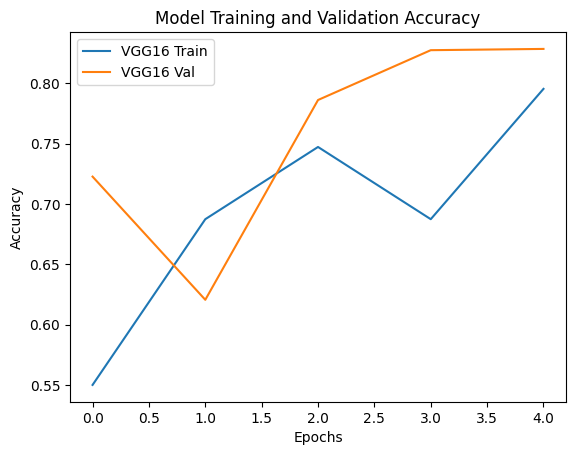

In [ ]:
# Plot training accuracy
plt.plot(history_vgg16.history['accuracy'], label='VGG16 Train')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Val')

plt.legend()
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

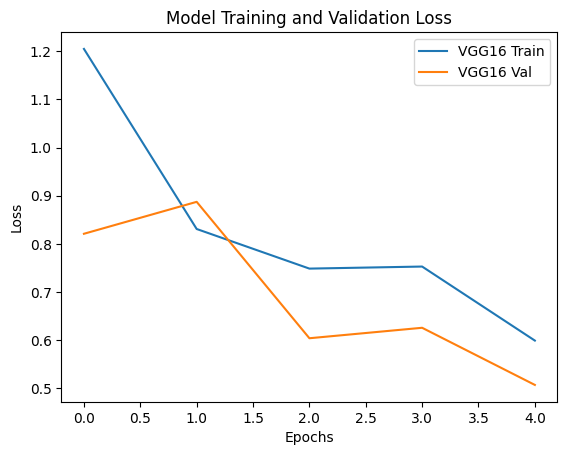

In [ ]:
# Plot training loss
plt.plot(history_vgg16.history['loss'], label='VGG16 Train')
plt.plot(history_vgg16.history['val_loss'], label='VGG16 Val')

plt.legend()
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**MobileNetV2**

In [ ]:
print("Training MobileNetV2...")
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model = build_model(mobilenet_base, num_classes)

history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size
)

mobilenet_test_loss, mobilenet_test_accuracy = mobilenet_model.evaluate(test_generator)
print(f"MobileNetV2 Test Accuracy: {mobilenet_test_accuracy:.2f}")


Training MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 390s 4s/step - accuracy: 0.7618 - loss: 0.6418 - val_accuracy: 0.9093 - val_loss: 0.2439
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9688 - loss: 0.1641 - val_accuracy: 0.8966 - val_loss: 0.4051
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 424s 4s/step - accuracy: 0.9330 - loss: 0.1958 - val_accuracy: 0.9536 - val_loss: 0.1208
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9062 - loss: 0.2210 - val_accuracy: 0.8276 - val_loss: 0.3970
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 361s 4s/step - accuracy: 0.9614 - loss: 0.1207 - val_accuracy: 0.9325 - val_loss: 0.1842
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9657 - loss: 0.0912
MobileNetV2 Test Accuracy: 0.93


In [ ]:
print(f"MobileNetV2 Test Accuracy: {mobilenet_test_accuracy:.2f}")

MobileNetV2 Test Accuracy: 0.93


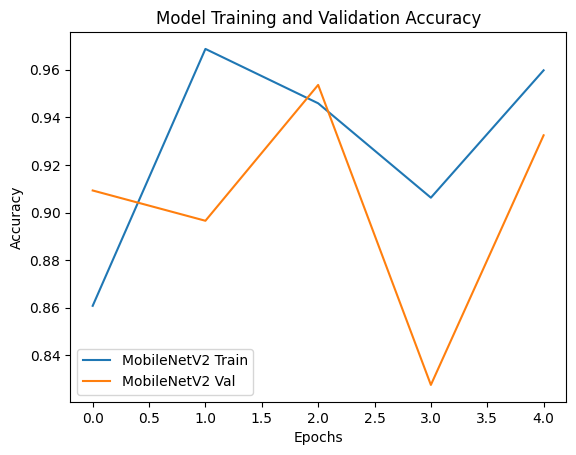

In [ ]:
# Plot training accuracy
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 Val')

plt.legend()
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

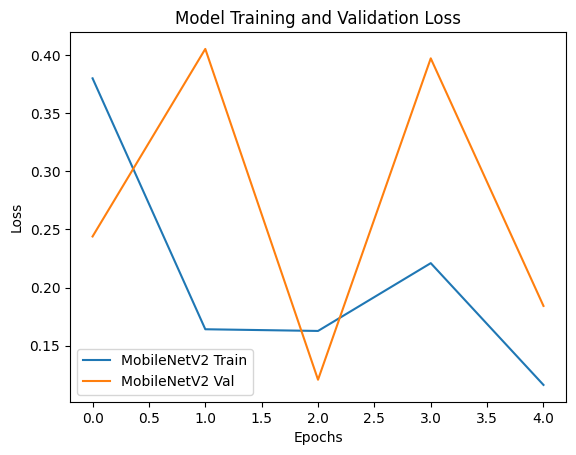

In [ ]:
# Plot training loss
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2 Val')

plt.legend()
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**ResNet50**

In [ ]:
print("Training ResNet50...")
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = build_model(resnet_base, num_classes)

history_resnet = resnet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=val_generator.samples // batch_size
)

resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_generator)
print(f"ResNet50 Test Accuracy: {resnet_test_accuracy:.2f}")


Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 907s 9s/step - accuracy: 0.2708 - loss: 1.7590 - val_accuracy: 0.3165 - val_loss: 1.5388
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 434ms/step - accuracy: 0.2188 - loss: 1.6321 - val_accuracy: 0.2759 - val_loss: 1.5446
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 933s 9s/step - accuracy: 0.3514 - loss: 1.5058 - val_accuracy: 0.4042 - val_loss: 1.4566
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.3438 - loss: 1.5326 - val_accuracy: 0.4483 - val_loss: 1.4263
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 899s 9s/step - accuracy: 0.3607 - loss: 1.5006 - val_accuracy: 0.4073 - val_loss: 1.4744
32/32 ━━━━━━━━━━━━━━━━━━━━ 214s 7s/step - accuracy: 0.5122 - loss: 1.2466
ResNet50 Test Accuracy: 0.39


In [ ]:
print(f"ResNet50 Test Accuracy: {resnet_test_accuracy:.2f}")


ResNet50 Test Accuracy: 0.39


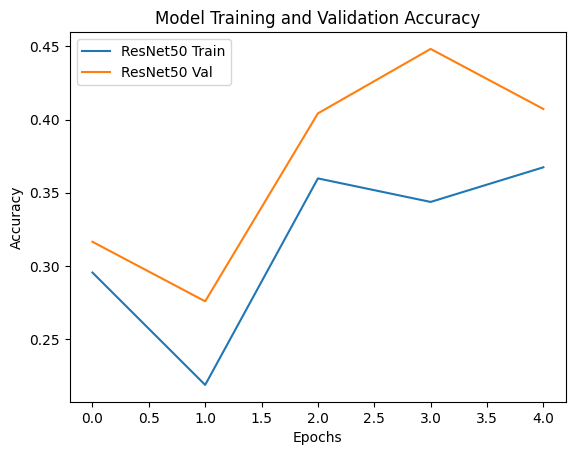

In [ ]:
# Plot training accuracy
plt.plot(history_resnet.history['accuracy'], label='ResNet50 Train')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50 Val')

plt.legend()
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

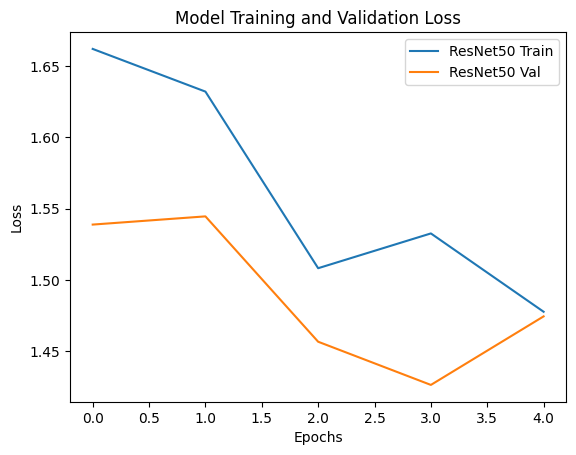

In [ ]:
plt.plot(history_resnet.history['loss'], label='ResNet50 Train')
plt.plot(history_resnet.history['val_loss'], label='ResNet50 Val')

plt.legend()
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

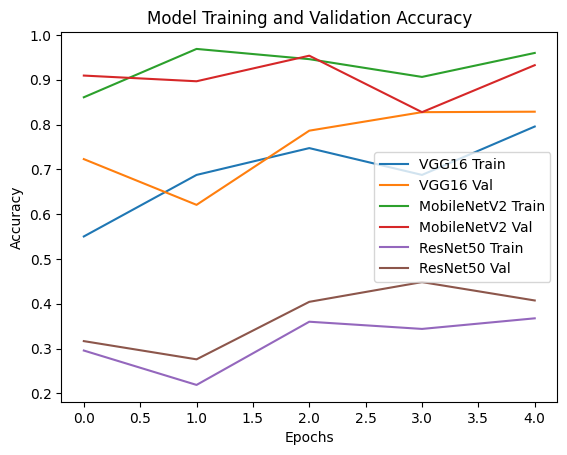

In [ ]:
# Plot training accuracy
plt.plot(history_vgg16.history['accuracy'], label='VGG16 Train')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Val')

plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2 Val')

plt.plot(history_resnet.history['accuracy'], label='ResNet50 Train')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50 Val')

plt.legend()
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


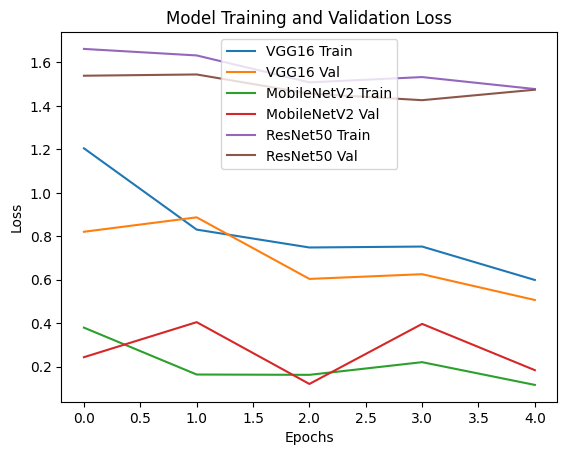

In [ ]:
# Plot training loss
plt.plot(history_vgg16.history['loss'], label='VGG16 Train')
plt.plot(history_vgg16.history['val_loss'], label='VGG16 Val')

plt.plot(history_mobilenet.history['loss'], label='MobileNetV2 Train')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNetV2 Val')

plt.plot(history_resnet.history['loss'], label='ResNet50 Train')
plt.plot(history_resnet.history['val_loss'], label='ResNet50 Val')

plt.legend()
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
print("Model Comparison:")
print(f"VGG16 Test Accuracy: {vgg16_test_accuracy:.2f}")
print(f"MobileNetV2 Test Accuracy: {mobilenet_test_accuracy:.2f}")
print(f"ResNet50 Test Accuracy: {resnet_test_accuracy:.2f}")


Model Comparison:
VGG16 Test Accuracy: 0.84
MobileNetV2 Test Accuracy: 0.93
ResNet50 Test Accuracy: 0.39


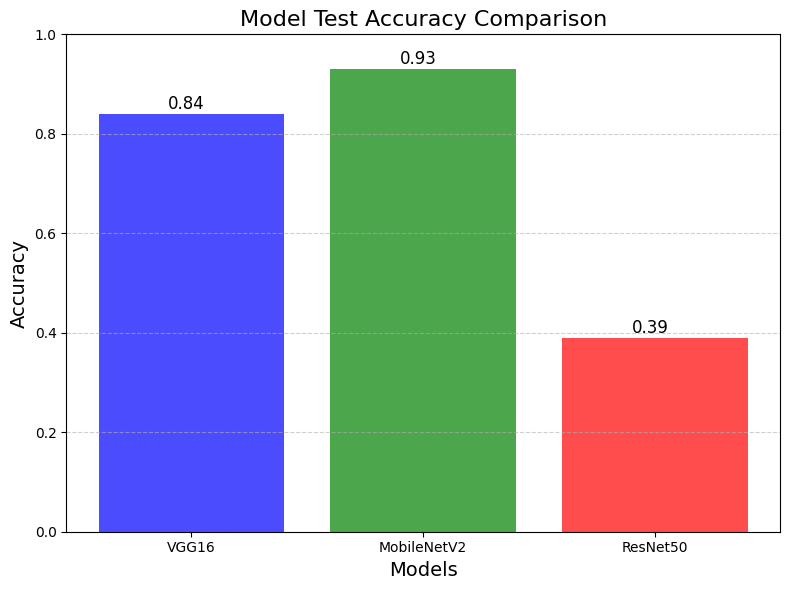

In [ ]:
import matplotlib.pyplot as plt

# Model names and corresponding test accuracies
models = ['VGG16', 'MobileNetV2', 'ResNet50']
accuracies = [0.84, 0.93, 0.39,]

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red',], alpha=0.7)

# Add data labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f"{bar.get_height():.2f}", fontsize=12)

# Customize the plot
plt.title('Model Test Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


Evaluating ResNet50...
32/32 ━━━━━━━━━━━━━━━━━━━━ 255s 8s/step
Classification Report for ResNet50:
                              precision    recall  f1-score   support

                    Agaricus       0.46      0.87      0.60       214
        Blue_Oyster_Mushroom       0.29      0.02      0.03       120
             Oyster_Mushroom       1.00      0.01      0.02       191
    Phoenix_Oyster_Mushrooms       0.00      0.00      0.00       117
    Phoenix_Oyster_Mushrooms       0.38      0.68      0.48       187
Poisonous_Mushroom_Sporocarp       0.32      0.44      0.37       192

                    accuracy                           0.39      1021
                   macro avg       0.41      0.34      0.25      1021
                weighted avg       0.45      0.39      0.29      1021



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


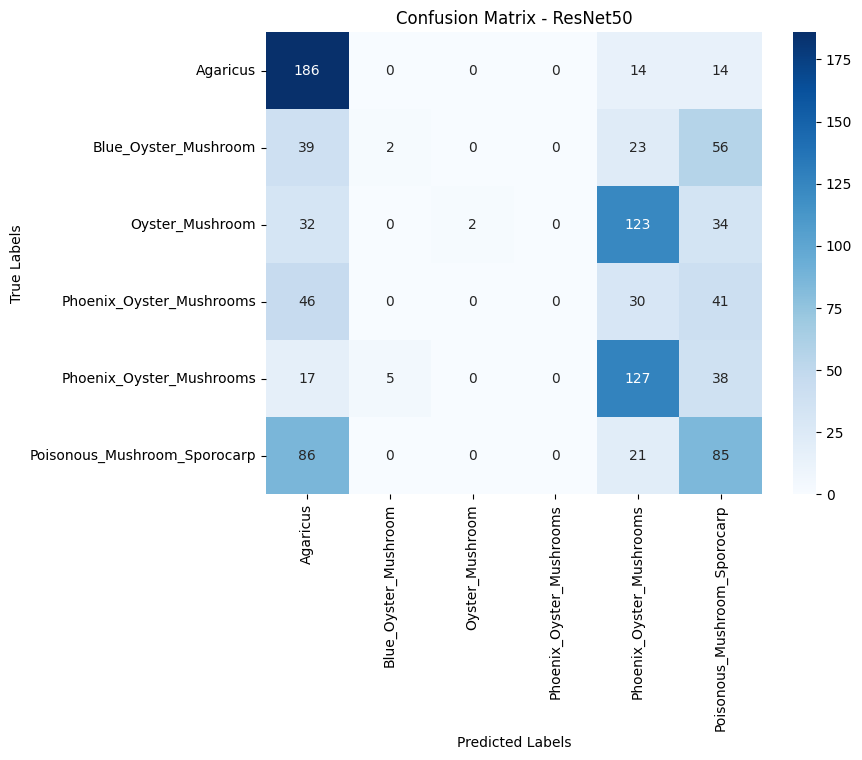

Evaluating MobileNet...
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step
Classification Report for MobileNet:
                              precision    recall  f1-score   support

                    Agaricus       0.80      1.00      0.89       214
        Blue_Oyster_Mushroom       0.99      0.96      0.97       120
             Oyster_Mushroom       0.96      0.91      0.93       191
    Phoenix_Oyster_Mushrooms       0.94      0.95      0.94       117
    Phoenix_Oyster_Mushrooms       0.98      0.97      0.97       187
Poisonous_Mushroom_Sporocarp       0.97      0.79      0.87       192

                    accuracy                           0.93      1021
                   macro avg       0.94      0.93      0.93      1021
                weighted avg       0.93      0.93      0.93      1021



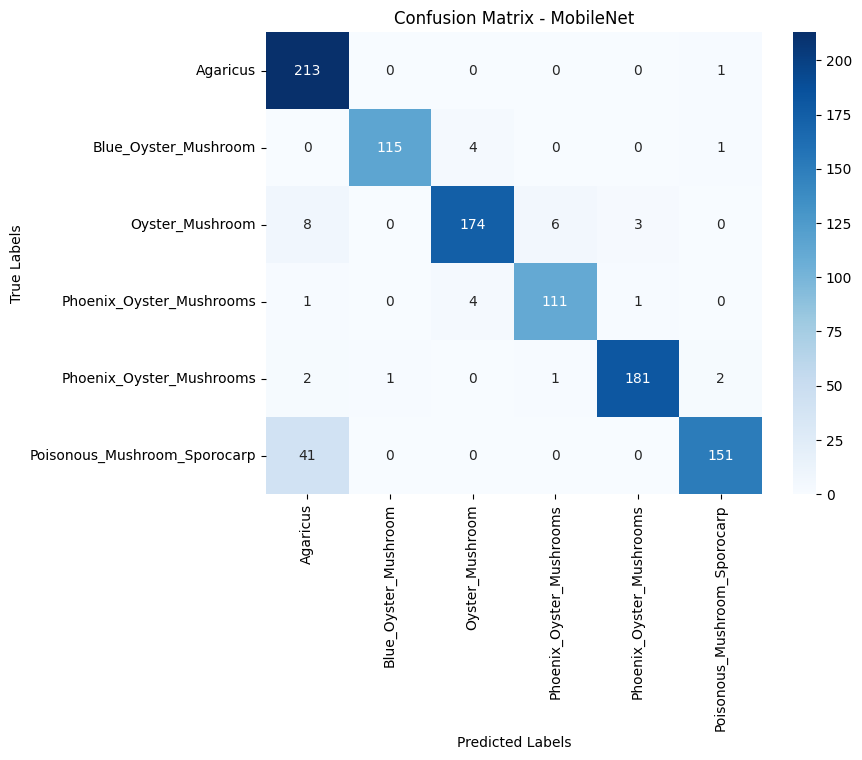

Evaluating VGG16...
32/32 ━━━━━━━━━━━━━━━━━━━━ 632s 20s/step
Classification Report for VGG16:
                              precision    recall  f1-score   support

                    Agaricus       0.80      0.94      0.86       214
        Blue_Oyster_Mushroom       0.91      0.96      0.93       120
             Oyster_Mushroom       0.92      0.82      0.86       191
    Phoenix_Oyster_Mushrooms       0.76      0.79      0.77       117
    Phoenix_Oyster_Mushrooms       0.76      0.80      0.78       187
Poisonous_Mushroom_Sporocarp       0.94      0.76      0.84       192

                    accuracy                           0.84      1021
                   macro avg       0.85      0.84      0.84      1021
                weighted avg       0.85      0.84      0.84      1021



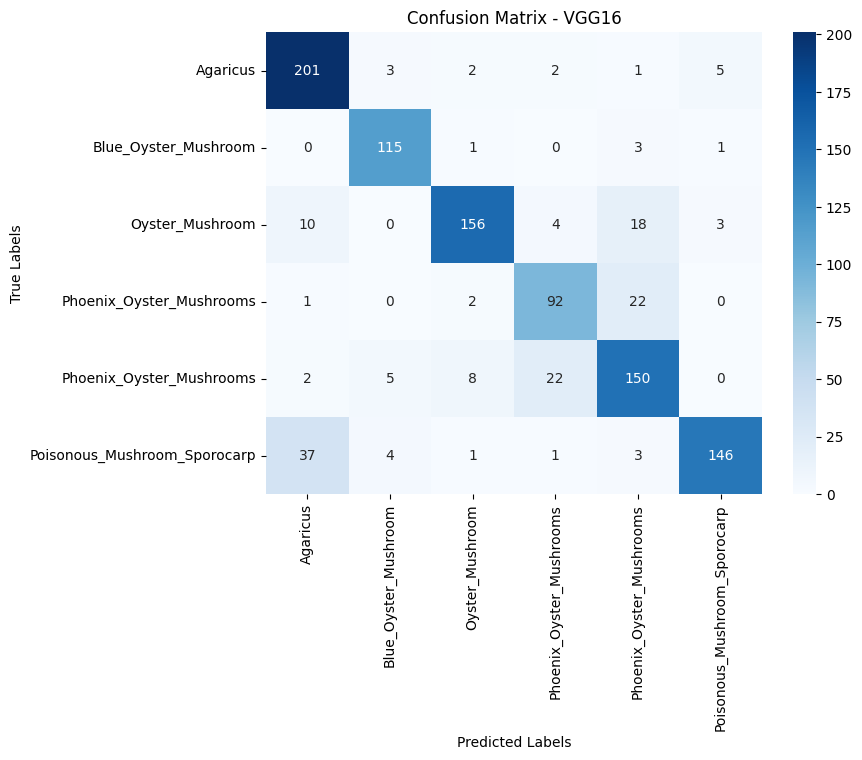

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define function to plot confusion matrix
def plot_confusion_matrix(model_name, y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Common settings
class_labels = ['Agaricus', 'Blue_Oyster_Mushroom', 'Oyster_Mushroom',
                'Phoenix_Oyster_Mushrooms', 'Phoenix_Oyster_Mushrooms', 'Poisonous_Mushroom_Sporocarp']

# ResNet50
print("Evaluating ResNet50...")
resnet_predictions = resnet_model.predict(test_generator)
resnet_predicted_classes = np.argmax(resnet_predictions, axis=1)
resnet_true_classes = test_generator.classes

print("Classification Report for ResNet50:")
print(classification_report(resnet_true_classes, resnet_predicted_classes, target_names=class_labels))

plot_confusion_matrix("ResNet50", resnet_true_classes, resnet_predicted_classes, class_labels)

# MobileNet
print("Evaluating MobileNet...")
mobilenet_predictions = mobilenet_model.predict(test_generator)
mobilenet_predicted_classes = np.argmax(mobilenet_predictions, axis=1)
mobilenet_true_classes = test_generator.classes

print("Classification Report for MobileNet:")
print(classification_report(mobilenet_true_classes, mobilenet_predicted_classes, target_names=class_labels))

plot_confusion_matrix("MobileNet", mobilenet_true_classes, mobilenet_predicted_classes, class_labels)

# VGG16
print("Evaluating VGG16...")
vgg16_predictions = vgg16_model.predict(test_generator)
vgg16_predicted_classes = np.argmax(vgg16_predictions, axis=1)
vgg16_true_classes = test_generator.classes

print("Classification Report for VGG16:")
print(classification_report(vgg16_true_classes, vgg16_predicted_classes, target_names=class_labels))

plot_confusion_matrix("VGG16", vgg16_true_classes, vgg16_predicted_classes, class_labels)


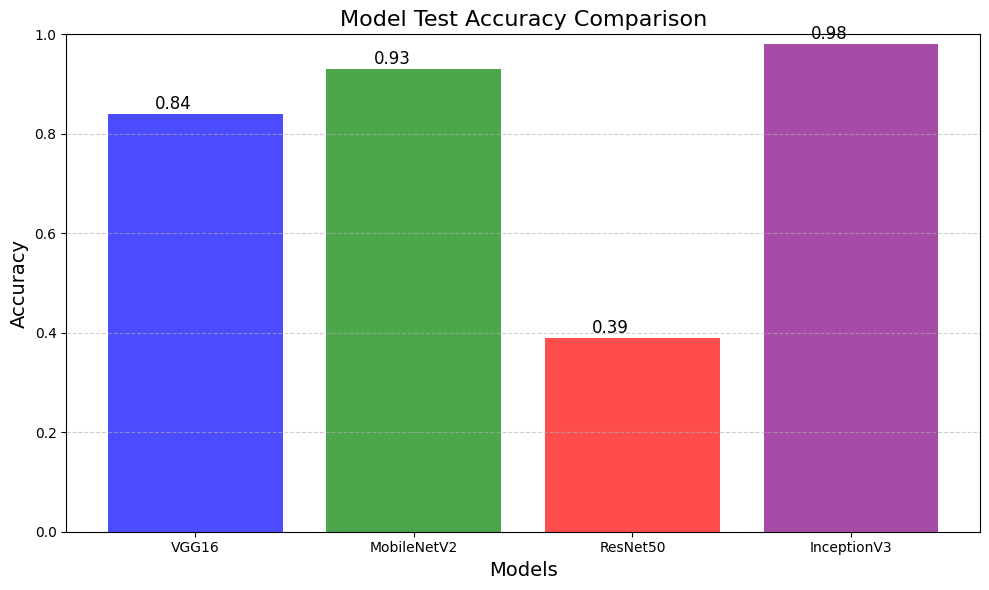

In [ ]:
import matplotlib.pyplot as plt

# Model names and corresponding test accuracies
models = ['VGG16', 'MobileNetV2', 'ResNet50', 'InceptionV3']
accuracies = [0.84, 0.93, 0.39, 0.98]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'], alpha=0.7)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1,
             bar.get_height() + 0.01,
             f"{bar.get_height():.2f}",
             fontsize=12, ha='center')

plt.title('Model Test Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
